In [1]:
import os
import sys
import glob
import datetime

from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms

In [2]:
DATA_PATH = "/media/xiaolong/9bbdf31a-3238-4691-845c-7f9126769abe/Dataset/stanford-cars-dataset/data/cars_train" 
IMAGE_DIM = (32, 32, 3)
BATCH_SIZE = 64
DEVICE = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7-> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
class Generator(nn.Module):
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, "Should be divided 16"
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0] * self.init_dim[1] * 512),
            nn.ReLU()
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 512, self.init_dim[0], self.init_dim[1])
        x = self.conv(x)
        return x

In [5]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)

In [6]:
class CARDataset(Dataset):
    def __init__(self, data_path, tansform=None):
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, "*/*.jpg")))
        
        gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848,
                   5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        for fpath in self.fpaths:
            if any([str(i) in fpath for i in gray_lst]):
                self.fpaths.remove(fpath)
        
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img
    
    def __len__(self):
        return len(self.fpaths)

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_DIM[0], IMAGE_DIM[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = CARDataset(DATA_PATH, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=8
)

In [8]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [9]:
step = 0
EPOCHS = 10
N_CRITIC = 1 # for training more k steps about Discriminator
N_NOISE = 100

In [10]:
D_labels = torch.ones([BATCH_SIZE, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([BATCH_SIZE, 1]).to(DEVICE) # Discriminator Label to fake

In [11]:
def get_sample_image(G, n_noise):
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1)
    result = (y_hat.detach().cpu().numpy() + 1) / 2.0
    return result

In [12]:
for epoch in range(EPOCHS):
    for images in tqdm(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)
        
        z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)
        G(z)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % N_CRITIC == 0:
            # Training Generator
            z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)
            
            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        if step % 500 == 0:
            print("Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}".format(
                epoch, EPOCHS, step, D_loss.item(), G_loss.item()
            ))
            G.eval()
            img = get_sample_image(G, N_NOISE)
            plt.imsave("samples/dcgan_step{:05d}.jpg".format(step), img[0])
            G.train()
        step += 1

  2%|▏         | 2/126 [00:01<00:58,  2.14it/s]

Epoch: 0/10, Step: 0, D Loss: 1.3978, G Loss: 0.7397


 98%|█████████▊| 124/126 [00:25<00:00,  5.07it/s]

Epoch: 3/10, Step: 500, D Loss: 0.7252, G Loss: 2.1827


 95%|█████████▌| 120/126 [00:24<00:01,  5.08it/s]

Epoch: 7/10, Step: 1000, D Loss: 0.9676, G Loss: 1.8145


100%|██████████| 126/126 [00:26<00:00,  4.77it/s]


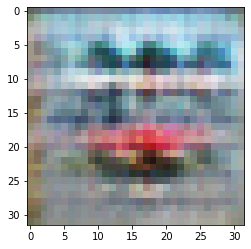

In [13]:
# generation to image
G.eval()
plt.imshow(get_sample_image(G, N_NOISE)[0])

In [14]:
def save_checkpoint(state, file_name='checkpoint.pth'):
    torch.save(state, file_name)

In [15]:
# Saving params
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
            'dcgan.pth.tar')